In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels import graphics
import itertools
from sklearn import metrics
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import ensemble
from sklearn import preprocessing as pp
from sklearn import svm
from scipy import stats

%matplotlib inline

# Data preparation

**To run this notebook, ensure that the location in the cell below matches the location of the raw data file from this repository.**

In [2]:
rawdata = pd.read_csv(r'data/rawdata.csv')  # insert the location of the included data file
data = rawdata.copy()
del data['Unnamed: 0']
data.index = data.stdntid  # make student ID the index of the data instead of a predictor variable column
del data['stdntid']
data.tail(5)

,gender,race,birthmonth,birthday,birthyear,FLAGSGK,FLAGSG1,FLAGSG2,FLAGSG3,flaggk,...,hsactcomp,hsacttot,hsactenglish,hsactmath,hsactread,hsactscience,hssatconverted,hsactconverted,hsgrdadd,hsgrdcol
stdntid,,,,,,,,,,,,,,,,,,,,,
21596,2.0,1.0,NaN,NaN,NaN,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21597,2.0,1.0,8.0,8.0,1979.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21598,2.0,2.0,4.0,18.0,1980.0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21599,2.0,1.0,3.0,27.0,1980.0,0,0,0,1,0,...,23.0,92.0,25.0,20.0,29.0,18.0,1000.0,23.0,NaN,NaN
21600,2.0,1.0,5.0,5.0,1980.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [3]:
data.describe()

,gender,race,birthmonth,birthday,birthyear,FLAGSGK,FLAGSG1,FLAGSG2,FLAGSG3,flaggk,...,hsactcomp,hsacttot,hsactenglish,hsactmath,hsactread,hsactscience,hssatconverted,hsactconverted,hsgrdadd,hsgrdcol
count,11581.000000,11467.000000,11533.000000,11533.000000,11533.000000,11601.000000,11601.000000,11601.000000,11601.000000,11601.000000,...,3754.000000,3754.000000,3755.000000,3755.000000,3754.000000,3754.000000,3879.000000,3879.000000,4992.000000,4992.000000
mean,1.471203,1.389204,6.446718,15.524582,1979.535507,0.545212,0.588656,0.589604,0.586329,0.509180,...,19.135056,76.021843,18.982690,18.304394,19.539425,19.193127,896.635731,19.229183,1.070913,0.775641
std,0.499192,0.551229,3.379414,8.888810,0.628461,0.497973,0.492099,0.491927,0.492512,0.499937,...,4.499949,17.996004,5.492376,4.424200,5.760072,4.374824,191.655875,4.544243,0.800082,0.417201
min,1.000000,1.000000,1.000000,1.000000,1977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,35.000000,5.000000,8.000000,3.000000,7.000000,400.000000,9.000000,0.000000,0.000000
25%,1.000000,1.000000,4.000000,8.000000,1979.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.000000,62.000000,15.000000,15.000000,15.000000,16.000000,770.000000,16.000000,1.000000,1.000000
50%,1.000000,1.000000,7.000000,15.000000,1980.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,74.000000,19.000000,17.000000,19.000000,19.000000,910.000000,19.000000,1.000000,1.000000
75%,2.000000,2.000000,9.000000,23.000000,1980.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,22.000000,87.000000,23.000000,20.000000,23.000000,22.000000,1030.000000,22.000000,1.000000,1.000000
max,2.000000,6.000000,12.000000,31.000000,1981.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,34.000000,136.000000,36.000000,36.000000,36.000000,36.000000,1560.000000,34.000000,4.000000,1.000000


Student genders are recorded as 1: male, 2: female. We subtract 1 from this column in order to follow a more conventional 0, 1 scheme for binary categorical variables.

In [4]:
data.rename(columns={'gender': 'female'}, inplace=True)
data['female'] = data['female'] - 1

The "race" variable was originally recorded thus:

1. White
2. Black
3. Asian
4. Hispanic
5. Native American
6. Other

We convert these six categories into five 0, 1 binary categorical indicator variables. For each student, at most one of the five has value 1. If all five have value 0, then "Other" was listed as the student's race.

In general, when a categorical variable has $J$ levels, we create $J-1$ dummy variables to encode them. Each of the $J-1$ dummy variables represents one level; to indicate the final level, all $J-1$ variables are made 0.

In [5]:
data.insert(1, 'white', data.race.apply(lambda x: 1 if x == 1 else 0))
data.insert(2, 'black', data.race.apply(lambda x: 1 if x == 2 else 0))
data.insert(3, 'asian', data.race.apply(lambda x: 1 if x == 3 else 0))
data.insert(4, 'hispanic', data.race.apply(lambda x: 1 if x == 4 else 0))
data.insert(5, 'nativeamerican', data.race.apply(lambda x: 1 if x == 5 else 0))

# if all zero, then race is "other"

data.drop('race', 1, inplace=True)

The data set lists each student's birth year, birth month, and birth day in separate columns. We use timestamps to extract an age value for each student. This value represents the student's age in years on September 1, 1985, approximately when the study's first school year began. This student cohort was starting kindergarten.

Some days were incorrectly recorded (e.g., February 30). These are fixed below.

In [6]:
for i in data.index:
    if np.isnan(data.loc[i, 'birthyear']) or np.isnan(data.loc[i, 'birthmonth']) or np.isnan(data.loc[i, 'birthday']):
        continue
    try:
        data.loc[i, 'birthday'] = (pd.Timestamp(1985, 9, 1) -
                                   pd.Timestamp(int(data.loc[i, 'birthyear']), int(data.loc[i, 'birthmonth']),
                                                int(data.loc[i, 'birthday']))).days/365.2425
    except ValueError:  # to fix incorrectly recorded dates
        data.loc[i, 'birthday'] = 28
        data.loc[i, 'birthday'] = (pd.Timestamp(1985, 9, 1) -
                                   pd.Timestamp(int(data.loc[i, 'birthyear']), int(data.loc[i, 'birthmonth']),
                                                int(data.loc[i, 'birthday']))).days/365.2425

del data['birthmonth'], data['birthyear']
data.rename(columns={'birthday': 'age'}, inplace=True)

# gives age of student in years upon starting kindergarten in 1985

Class size was one of the primary variables of interest in the original study. A categorical variable recorded each student's classroom type:

1. Small
2. Regular
3. Regular with aide

We convert this into two indicator variables. If both are 0, then the classroom type is "regular with aide."

Next, we perform a similar operation on school location, originally recorded thus:

1. Inner city
2. Suburban
3. Rural
4. Urban

Three indicator variables are created for each year. Since we'll only be examining the K–3 data, we do not go beyond third grade. If all are 0, then the school location is "urban."

In [7]:
data['ctsmall'] = data.cmpstype.apply(lambda x: 1 if x == 1 else 0)
data['ctregular'] = data.cmpstype.apply(lambda x: 1 if x == 2 else 0)

# if both zero, then regular with aide

data.drop('cmpstype', 1, inplace=True)

In [8]:
data['kinnercity'] = data.gksurban.apply(lambda x: 1 if x == 1 else 0)
data['ksuburban'] = data.gksurban.apply(lambda x: 1 if x == 2 else 0)
data['krural'] = data.gksurban.apply(lambda x: 1 if x == 3 else 0)
data.drop('gksurban', 1, inplace=True)

data['1innercity'] = data.g1surban.apply(lambda x: 1 if x == 1 else 0)
data['1suburban'] = data.g1surban.apply(lambda x: 1 if x == 2 else 0)
data['1rural'] = data.g1surban.apply(lambda x: 1 if x == 3 else 0)
data.drop('g1surban', 1, inplace=True)

data['2innercity'] = data.g2surban.apply(lambda x: 1 if x == 1 else 0)
data['2suburban'] = data.g2surban.apply(lambda x: 1 if x == 2 else 0)
data['2rural'] = data.g2surban.apply(lambda x: 1 if x == 3 else 0)
data.drop('g2surban', 1, inplace=True)

data['3innercity'] = data.g3surban.apply(lambda x: 1 if x == 1 else 0)
data['3suburban'] = data.g3surban.apply(lambda x: 1 if x == 2 else 0)
data['3rural'] = data.g3surban.apply(lambda x: 1 if x == 3 else 0)
data.drop('g3surban', 1, inplace=True)

# if all zero, then urban

We detect a mistake in the data set. For all of K–3, only a few hundred teachers (out of over 45,000 possible entries) are listed as male. Approximately 57% of the teachers are female and the rest of the values are missing. This suggests that the vast majority of male teachers did not have their genders recorded.

The loop below fills in the missing values for K–3 and changes the teacher gender columns to fit the 0, 1 scheme. 1 indicates female.

Next, we apply the same re-encoding operation to the teacher race variables for K–3:

1. White
2. Black
3. Asian
4. Hispanic
5. Native American
6. Other

Again, if all five newly created variables are 0, then the teacher race is "Other."

In [9]:
for g in list('k123'):
    data['g{}tgen'.format(g)].fillna(1, inplace=True)
    data.rename(columns={'g{}tgen'.format(g): '{}tfemale'.format(g)}, inplace=True)
    data['{}tfemale'.format(g)] = data['{}tfemale'.format(g)] - 1

In [10]:
data['ktwhite'] = data.gktrace.apply(lambda x: 1 if x == 1 else 0)
data['ktblack'] = data.gktrace.apply(lambda x: 1 if x == 2 else 0)
data['ktasian'] = data.gktrace.apply(lambda x: 1 if x == 3 else 0)
data['kthispanic'] = data.gktrace.apply(lambda x: 1 if x == 4 else 0)
data['ktnativeamerican'] = data.gktrace.apply(lambda x: 1 if x == 5 else 0)
data.drop('gktrace', 1, inplace=True)

data['1twhite'] = data.g1trace.apply(lambda x: 1 if x == 1 else 0)
data['1tblack'] = data.g1trace.apply(lambda x: 1 if x == 2 else 0)
data['1tasian'] = data.g1trace.apply(lambda x: 1 if x == 3 else 0)
data['1thispanic'] = data.g1trace.apply(lambda x: 1 if x == 4 else 0)
data['1tnativeamerican'] = data.g1trace.apply(lambda x: 1 if x == 5 else 0)
data.drop('g1trace', 1, inplace=True)

data['2twhite'] = data.g2trace.apply(lambda x: 1 if x == 1 else 0)
data['2tblack'] = data.g2trace.apply(lambda x: 1 if x == 2 else 0)
data['2tasian'] = data.g2trace.apply(lambda x: 1 if x == 3 else 0)
data['2thispanic'] = data.g2trace.apply(lambda x: 1 if x == 4 else 0)
data['2tnativeamerican'] = data.g2trace.apply(lambda x: 1 if x == 5 else 0)
data.drop('g2trace', 1, inplace=True)

data['3twhite'] = data.g3trace.apply(lambda x: 1 if x == 1 else 0)
data['3tblack'] = data.g3trace.apply(lambda x: 1 if x == 2 else 0)
data['3tasian'] = data.g3trace.apply(lambda x: 1 if x == 3 else 0)
data['3thispanic'] = data.g3trace.apply(lambda x: 1 if x == 4 else 0)
data['3tnativeamerican'] = data.g3trace.apply(lambda x: 1 if x == 5 else 0)
data.drop('g3trace', 1, inplace=True)

# if all zero, then race is "other"

The next two variables indicate whether the student was eligible for free lunch and whether the student was in a special education program for each grade. Free lunch eligibility is determined by household income, so eligibility indicates a lower socioeconomic status. Each variable was originally encoded thus:

1. Yes
2. No

We apply this operation to change them to:

<ol start="0">
  <li>No</li>
  <li>Yes</li>
</ol>

Special education status was not available beyond grade 1.

In [11]:
data.gkfreelunch = data.gkfreelunch.apply(lambda x: x % 2)
data.g1freelunch = data.g1freelunch.apply(lambda x: x % 2)
data.g2freelunch = data.g2freelunch.apply(lambda x: x % 2)
data.g3freelunch = data.g3freelunch.apply(lambda x: x % 2)

In [12]:
data.gkspeced = data.gkspeced.apply(lambda x: x % 2)
data.g1speced = data.g1speced.apply(lambda x: x % 2)

This loop renames some test score variables for consistency and ease of use later on.

In [13]:
for g in list('k123'):
    data.rename(columns={'g{}tlistss'.format(g): 'g{}tlstnss'.format(g)}, inplace=True)
    data.rename(columns={'g{}wordskillss'.format(g): 'g{}twordss'.format(g)}, inplace=True)

In [14]:
#data.to_csv(r'processed/data.csv')
#data.corr().to_csv(r'processed/data_corr.csv')

# uncomment the first line above to save the cleaned data as a CSV file on your computer
# the second one gives a correlation chart between all columns

Now the data are ready for analysis. We wish to focus on grades K–3, so we create a new data set to include the students with complete K–3 information. The "flag" columns are indicator variables that signify whether a student's academic information is available for a certain school year. For instance, if "flaggk" is 0 for a particular student, then that student's kindergarten records are not available.

In [15]:
dataK3 = data.copy()
for g in list('k123'):
    dataK3 = dataK3[dataK3['flagg{}'.format(g)] == 1]

These columns are the ones we will use as independent variables. For our purposes, we do not need information past third grade. Many columns that have thousands of missing values are also dropped. Our dependent variables are the third grade test results in the four Stanford Achievement Test subjects: reading, mathematics, listening, and word skills.

In [16]:
featuresg3 = 'female white black asian hispanic nativeamerican age yearssmall kinnercity ksuburban krural ktwhite ktblack ktasian kthispanic ktnativeamerican gkthighdegree gktyears gkfreelunch gkabsent gktreadss gktmathss gktlstnss gktwordss 1innercity 1suburban 1rural 1twhite 1tblack 1tasian 1thispanic 1tnativeamerican g1thighdegree g1tyears g1freelunch g1absent g1treadss g1tmathss g1tlstnss g1twordss g1readbsraw g1mathbsraw 2innercity 2suburban 2rural 2twhite 2tblack 2tasian 2thispanic 2tnativeamerican g2thighdegree g2tyears g2freelunch g2treadss g2tmathss g2tlstnss g2twordss g2readbsraw g2mathbsraw 3innercity 3suburban 3rural 3twhite 3tblack 3tasian 3thispanic 3tnativeamerican g3thighdegree g3tyears g3freelunch g3absent g3treadss g3tmathss g3tlstnss g3twordss'.split()
featuresg3resp = 'g3treadss g3tmathss g3tlstnss g3twordss'.split()

In [17]:
dataK3 = dataK3[featuresg3].dropna()
dataK3.describe()

,female,white,black,asian,hispanic,nativeamerican,age,yearssmall,kinnercity,ksuburban,...,3thispanic,3tnativeamerican,g3thighdegree,g3tyears,g3freelunch,g3absent,g3treadss,g3tmathss,g3tlstnss,g3twordss
count,1955.000000,1955.000000,1955.000000,1955.000000,1955.0,1955.0,1955.000000,1955.000000,1955.000000,1955.000000,...,1955.0,1955.0,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000
mean,0.519182,0.749361,0.247059,0.003069,0.0,0.0,5.427497,1.457801,0.153964,0.184655,...,0.0,0.0,2.461893,13.605627,0.347315,5.887468,626.232737,628.443478,629.660870,623.668542
std,0.499760,0.433492,0.431412,0.055328,0.0,0.0,0.315149,1.793778,0.361007,0.388116,...,0.0,0.0,0.586400,8.459336,0.476239,5.562948,36.791364,39.861252,31.126711,43.545722
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.794739,0.000000,0.000000,0.000000,...,0.0,0.0,2.000000,0.000000,0.000000,0.000000,517.000000,515.000000,537.000000,509.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.174644,0.000000,0.000000,0.000000,...,0.0,0.0,2.000000,7.000000,0.000000,2.000000,600.000000,601.000000,608.000000,591.000000
50%,1.000000,1.000000,0.000000,0.000000,0.0,0.0,5.421056,0.000000,0.000000,0.000000,...,0.0,0.0,2.000000,13.000000,0.000000,4.000000,626.000000,626.000000,629.000000,624.000000
75%,1.000000,1.000000,0.000000,0.000000,0.0,0.0,5.659254,4.000000,0.000000,0.000000,...,0.0,0.0,3.000000,19.000000,1.000000,8.000000,650.000000,655.000000,649.000000,655.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,0.0,6.814651,4.000000,1.000000,1.000000,...,0.0,0.0,5.000000,38.000000,1.000000,55.000000,753.000000,774.000000,756.000000,740.000000


Examination of the data reveals that several indicator variables can be dropped because there are no remaining observations in those groups. Note that the remaining $J-1$ dummy variables still represent $J$ categories; the final category is represented by all zeroes.

In [18]:
del dataK3['hispanic']
del dataK3['nativeamerican']

# no Hispanic or Native American students remaining

del dataK3['ktblack']
del dataK3['ktasian']
del dataK3['kthispanic']
del dataK3['ktnativeamerican']
del dataK3['1tblack']
del dataK3['1tasian']
del dataK3['1thispanic']
del dataK3['1tnativeamerican']
del dataK3['2tblack']
del dataK3['2tasian']
del dataK3['2thispanic']
del dataK3['2tnativeamerican']
del dataK3['3tasian']
del dataK3['3thispanic']
del dataK3['3tnativeamerican']

# only white and black teachers except a few Asian ones in G3

This cell creates separate DataFrames for the independent and dependent variables for convenience. The unseparated one remains intact.

In [19]:
dataK3pred = dataK3.copy()

for col in featuresg3resp:
    del dataK3pred[col]

dataK3resp = dataK3[featuresg3resp]

In [20]:
#dataK3.to_csv(r'processed/dataK3.csv')
#dataK3.corr().to_csv(r'processed/dataK3_corr.csv')

# uncomment the first line above to save the cleaned K–3 data as a CSV file on your computer
# the second one gives a correlation chart between all covariates

# Exploratory data analysis

In [21]:
def bin_counts(df):
    return round((2 * len(df)) ** (1/3))
    
# determines how many bins to use in a histogram; based on research by Terrell and Scott

In [22]:
print('Distribution of sex: {} male, {} female'.format(len(dataK3) - dataK3['female'].sum(), dataK3['female'].sum()))

print('Distribution of race: {} white, {} black, {} Asian, {} other'.format(dataK3['white'].sum(), dataK3['black'].sum(), dataK3['asian'].sum(), len(dataK3) - dataK3['white'].sum() - dataK3['black'].sum() - dataK3['asian'].sum()))

Distribution of sex: 940.0 male, 1015.0 female
Distribution of race: 1465 white, 483 black, 6 Asian, 1 other


The histograms below show that all test scores are roughly normally distributed except for the word skills scores in second and third grade. The unusual distributions in those cases may be due to the test scoring method.

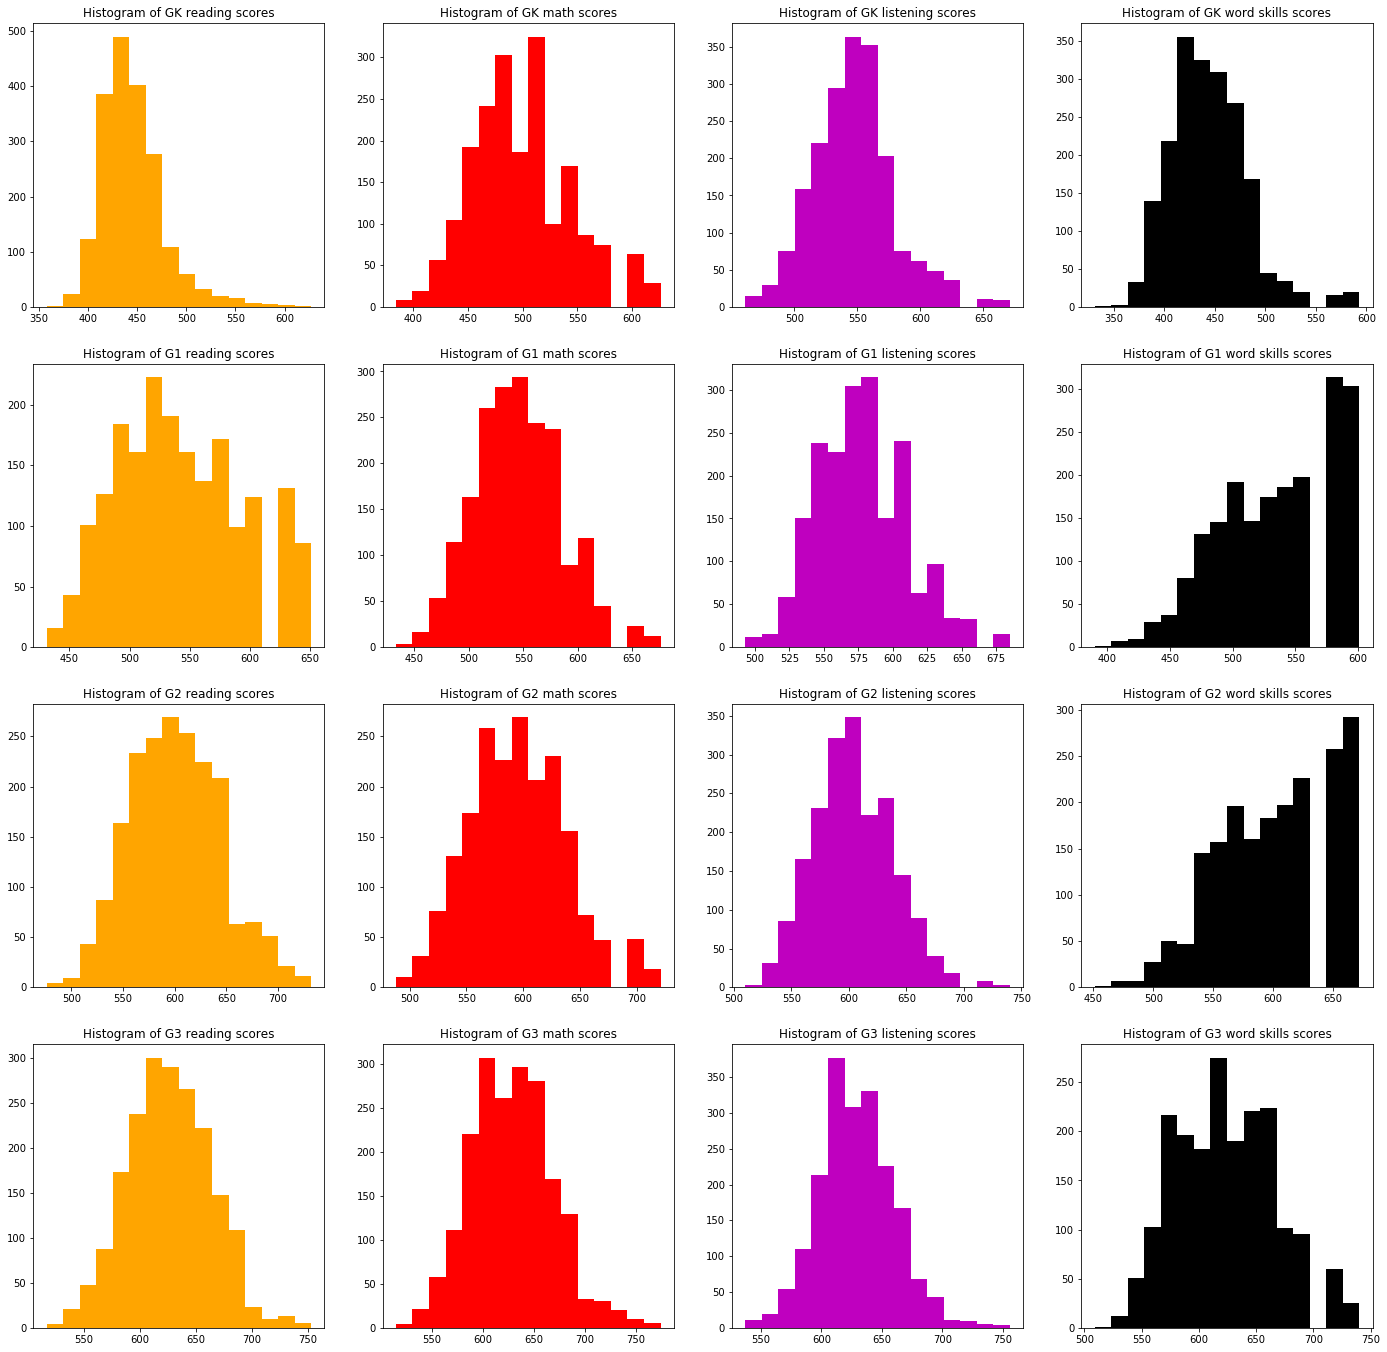

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24))

axes[0, 0].hist(dataK3['gktreadss'], bins=bin_counts(dataK3['gktreadss']), color='orange')
axes[0, 0].set_title('Histogram of GK reading scores')

axes[0, 1].hist(dataK3['gktmathss'], bins=bin_counts(dataK3['gktmathss']), color='r')
axes[0, 1].set_title('Histogram of GK math scores')

axes[0, 2].hist(dataK3['gktlstnss'], bins=bin_counts(dataK3['gktlstnss']), color='m')
axes[0, 2].set_title('Histogram of GK listening scores')

axes[0, 3].hist(dataK3['gktwordss'], bins=bin_counts(dataK3['gktwordss']), color='black')
axes[0, 3].set_title('Histogram of GK word skills scores')

axes[1, 0].hist(dataK3['g1treadss'], bins=bin_counts(dataK3['g1treadss']), color='orange')
axes[1, 0].set_title('Histogram of G1 reading scores')

axes[1, 1].hist(dataK3['g1tmathss'], bins=bin_counts(dataK3['g1tmathss']), color='r')
axes[1, 1].set_title('Histogram of G1 math scores')

axes[1, 2].hist(dataK3['g1tlstnss'], bins=bin_counts(dataK3['g1tlstnss']), color='m')
axes[1, 2].set_title('Histogram of G1 listening scores')

axes[1, 3].hist(dataK3['g1twordss'], bins=bin_counts(dataK3['g1twordss']), color='black')
axes[1, 3].set_title('Histogram of G1 word skills scores')

axes[2, 0].hist(dataK3['g2treadss'], bins=bin_counts(dataK3['g2treadss']), color='orange')
axes[2, 0].set_title('Histogram of G2 reading scores')

axes[2, 1].hist(dataK3['g2tmathss'], bins=bin_counts(dataK3['g2tmathss']), color='r')
axes[2, 1].set_title('Histogram of G2 math scores')

axes[2, 2].hist(dataK3['g2tlstnss'], bins=bin_counts(dataK3['g2tlstnss']), color='m')
axes[2, 2].set_title('Histogram of G2 listening scores')

axes[2, 3].hist(dataK3['g2twordss'], bins=bin_counts(dataK3['g2twordss']), color='black')
axes[2, 3].set_title('Histogram of G2 word skills scores')

axes[3, 0].hist(dataK3['g3treadss'], bins=bin_counts(dataK3['g3treadss']), color='orange')
axes[3, 0].set_title('Histogram of G3 reading scores')

axes[3, 1].hist(dataK3['g3tmathss'], bins=bin_counts(dataK3['g3tmathss']), color='r')
axes[3, 1].set_title('Histogram of G3 math scores')

axes[3, 2].hist(dataK3['g3tlstnss'], bins=bin_counts(dataK3['g3tlstnss']), color='m')
axes[3, 2].set_title('Histogram of G3 listening scores')

axes[3, 3].hist(dataK3['g3twordss'], bins=bin_counts(dataK3['g3twordss']), color='black')
axes[3, 3].set_title('Histogram of G3 word skills scores')

plt.show()

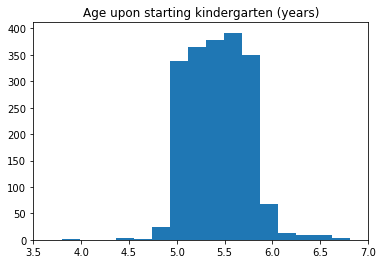

count    1955.000000
mean        5.427497
std         0.315149
min         3.794739
25%         5.174644
50%         5.421056
75%         5.659254
max         6.814651
Name: age, dtype: float64


In [24]:
plt.hist(dataK3.age, bins=bin_counts(dataK3.age))
plt.title('Age upon starting kindergarten (years)')
plt.xticks(np.linspace(3.5, 7, 8))

plt.show()

print(dataK3.age.describe())

# The impact of class size on test scores

In this section we conduct hypothesis testing to see whether class size has an impact on students' mean test scores. We split our data into four groups based on race of the student and size of the class. Only black and white students were considered because there were too few observations for the other races.

Data documentation explains that students were assigned to classes randomly, so it is unlikely that confounding would have influenced these results.

In [25]:
dataB = data[data['black'] == 1]
#dataB.to_csv(r'processed/dataB.csv')  # uncomment this line to generate a CSV file of the data
#dataB.corr().to_csv(r'processed/dataB_corr.csv')  # uncomment this line to generate a CSV file of the correlation chart

dataW = data[data['white'] == 1]
#dataW.to_csv(r'processed/dataW.csv')  # uncomment this line to generate a CSV file of the data
#dataW.corr().to_csv(r'processed/dataW_corr.csv')  # uncomment this line to generate a CSV file of the correlation chart

In [26]:
data_b_reg = dataB[dataB['ctsmall'] == 0]
data_b_small = dataB[dataB['ctsmall'] == 1]
data_w_reg = dataW[dataW['ctsmall'] == 0]
data_w_small = dataW[dataW['ctsmall'] == 1]

In [27]:
data_b_reg_kr = data_b_reg[['gktreadss']].dropna()
data_b_small_kr = data_b_small[['gktreadss']].dropna()
data_w_reg_kr = data_w_reg[['gktreadss']].dropna()
data_w_small_kr = data_w_small[['gktreadss']].dropna()

data_b_reg_km = data_b_reg[['gktmathss']].dropna()
data_b_small_km = data_b_small[['gktmathss']].dropna()
data_w_reg_km = data_w_reg[['gktmathss']].dropna()
data_w_small_km = data_w_small[['gktmathss']].dropna()

data_b_reg_kl = data_b_reg[['gktlstnss']].dropna()
data_b_small_kl = data_b_small[['gktlstnss']].dropna()
data_w_reg_kl = data_w_reg[['gktlstnss']].dropna()
data_w_small_kl = data_w_small[['gktlstnss']].dropna()

data_b_reg_kw = data_b_reg[['gktwordss']].dropna()
data_b_small_kw = data_b_small[['gktwordss']].dropna()
data_w_reg_kw = data_w_reg[['gktwordss']].dropna()
data_w_small_kw = data_w_small[['gktwordss']].dropna()

This cell generates upper and lower bounds for the histograms we will be creating. To make it easier to visually compare the distributions, we need to use the same bounds for the horizontal axis of each histogram. Four histograms are generated for each subject, one corresponding to each student race/class size combination. A vertical line indicates the mean of the distribution.

In [28]:
r_lb1 = min(min(data_b_reg_kr.values)[0], min(data_b_small_kr.values)[0], min(data_w_reg_kr.values)[0], min(data_w_small_kr.values)[0])
r_ub1 = max(max(data_b_reg_kr.values)[0], max(data_b_small_kr.values)[0], max(data_w_reg_kr.values)[0], max(data_w_small_kr.values)[0])
m_lb1 = min(min(data_b_reg_km.values)[0], min(data_b_small_km.values)[0], min(data_w_reg_km.values)[0], min(data_w_small_km.values)[0])
m_ub1 = max(max(data_b_reg_km.values)[0], max(data_b_small_km.values)[0], max(data_w_reg_km.values)[0], max(data_w_small_km.values)[0])
l_lb1 = min(min(data_b_reg_kl.values)[0], min(data_b_small_kl.values)[0], min(data_w_reg_kl.values)[0], min(data_w_small_kl.values)[0])
l_ub1 = max(max(data_b_reg_kl.values)[0], max(data_b_small_kl.values)[0], max(data_w_reg_kl.values)[0], max(data_w_small_kl.values)[0])
w_lb1 = min(min(data_b_reg_kw.values)[0], min(data_b_small_kw.values)[0], min(data_w_reg_kw.values)[0], min(data_w_small_kw.values)[0])
w_ub1 = max(max(data_b_reg_kw.values)[0], max(data_b_small_kw.values)[0], max(data_w_reg_kw.values)[0], max(data_w_small_kw.values)[0])

In [29]:
def cohend(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Cohen's $d$ is a measure of effect size. It is the difference in means between two groups divided by the weighted average of the standard deviations. The function below will be used to calculate Cohen's $d$. According to Cohen and Sawilowsky, a $|d|$ value of 0.2 is a small effect, 0.5 a medium effect, and 0.8 a large effect.

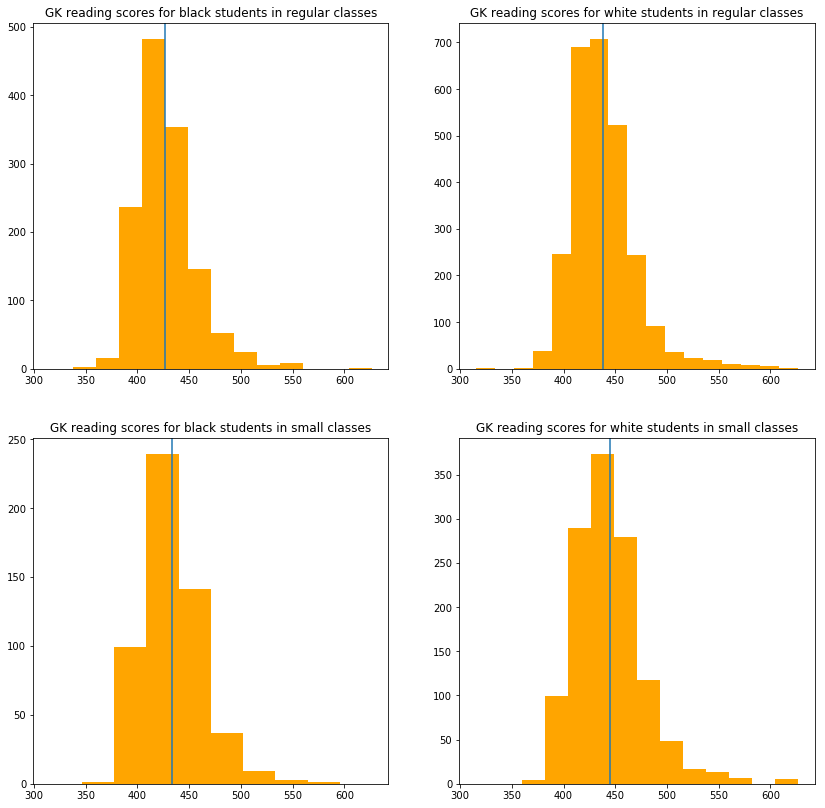

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_reg_kr.gktreadss, bins=bin_counts(data_b_reg_kr.gktreadss), color='orange', range=(r_lb1, r_ub1))
axes[0, 0].axvline(x = data_b_reg_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK reading scores for black students in regular classes')

axes[0, 1].hist(data_w_reg_kr.gktreadss, bins=bin_counts(data_w_reg_kr.gktreadss), color='orange', range=(r_lb1, r_ub1))
axes[0, 1].axvline(x = data_w_reg_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK reading scores for white students in regular classes')

axes[1, 0].hist(data_b_small_kr.gktreadss, bins=bin_counts(data_b_small_kr.gktreadss), color='orange', range=(r_lb1, r_ub1))
axes[1, 0].axvline(x = data_b_small_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK reading scores for black students in small classes')

axes[1, 1].hist(data_w_small_kr.gktreadss, bins=bin_counts(data_w_small_kr.gktreadss), color='orange', range=(r_lb1, r_ub1))
axes[1, 1].axvline(x = data_w_small_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK reading scores for white students in small classes')

plt.show()

In [31]:
print('Summary statistics for GK reading, black students in regular classes:\n{}'.format(data_b_reg_kr.gktreadss.describe()))
print('Summary statistics for GK reading, black students in small classes:\n{}'.format(data_b_small_kr.gktreadss.describe()))
print('Summary statistics for GK reading, white students in regular classes:\n{}'.format(data_w_reg_kr.gktreadss.describe()))
print('Summary statistics for GK reading, white students in small classes:\n{}'.format(data_w_small_kr.gktreadss.describe()))

Summary statistics for GK reading, black students in regular classes:
count    1328.000000
mean      427.056476
std        28.411482
min       346.000000
25%       408.000000
50%       422.000000
75%       440.000000
max       627.000000
Name: gktreadss, dtype: float64
Summary statistics for GK reading, black students in small classes:
count    530.000000
mean     433.596226
std       29.147289
min      376.000000
25%      413.000000
50%      430.000000
75%      448.000000
max      580.000000
Name: gktreadss, dtype: float64
Summary statistics for GK reading, white students in regular classes:
count    2649.000000
mean      438.491506
std        31.199836
min       315.000000
25%       418.000000
50%       434.000000
75%       453.000000
max       627.000000
Name: gktreadss, dtype: float64
Summary statistics for GK reading, white students in small classes:
count    1254.000000
mean      444.460925
std        34.230074
min       370.000000
25%       421.000000
50%       440.000000
75%   

Two t-tests are conducted below. The first one compares the mean of black students in regular classes with that of black students in small classes. The second does the same for white students.

In each case, the null hypothesis is that there is no difference between the two means. The alternative hypothesis is that there is a difference. The p-value represents the probability of seeing a difference at least as large as the one we've observed under the null hypothesis. A lower p-value represents stronger evidence against the null hypothesis.

In this case, there is extremely strong evidence for both races that small classes improve performance, although the effect size is relatively small.

In [32]:
stats.ttest_ind(data_b_reg_kr.gktreadss, data_b_small_kr.gktreadss, equal_var=False)

# for black students

Ttest_indResult(statistic=-4.3983238072195423, pvalue=1.2139461557620891e-05)

In [33]:
stats.ttest_ind(data_w_reg_kr.gktreadss, data_w_small_kr.gktreadss, equal_var=False)

# for white students

Ttest_indResult(statistic=-5.2318272814191769, pvalue=1.8326366929792349e-07)

In [34]:
print("Cohen's d for black kindergarten students, reading:", cohend(data_b_small_kr.gktreadss, data_b_reg_kr.gktreadss))
print("Cohen's d for white kindergarten students, reading:", cohend(data_w_small_kr.gktreadss, data_w_reg_kr.gktreadss))

Cohen's d for black kindergarten students, reading: 0.228476455607
Cohen's d for white kindergarten students, reading: 0.185359610865


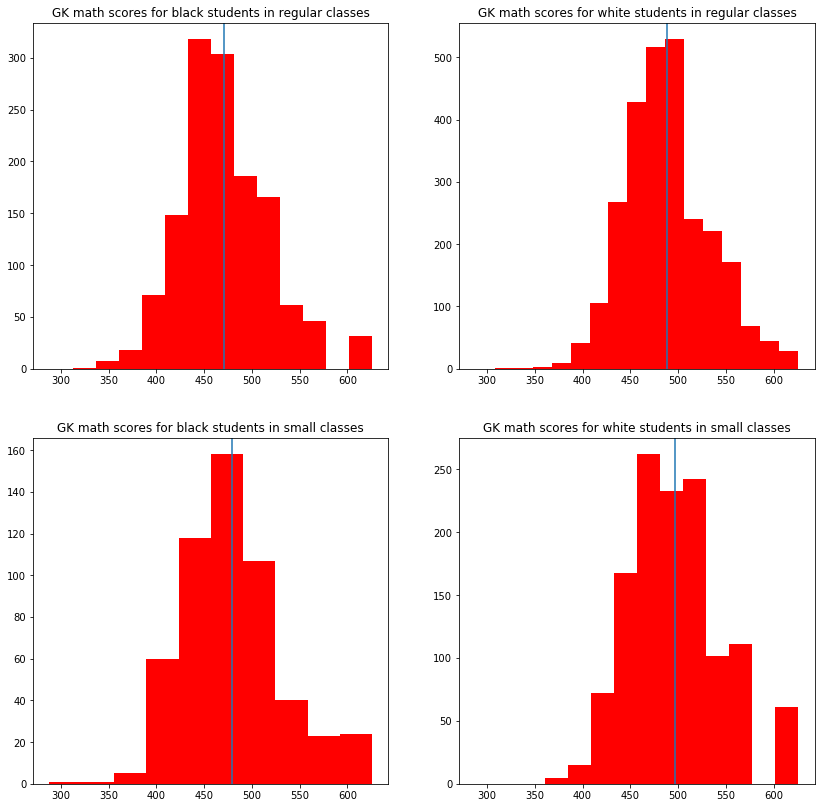

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_reg_km.gktmathss, bins=bin_counts(data_b_reg_km.gktmathss), color='r', range=(m_lb1, m_ub1))
axes[0, 0].axvline(x = data_b_reg_km.gktmathss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK math scores for black students in regular classes')

axes[0, 1].hist(data_w_reg_km.gktmathss, bins=bin_counts(data_w_reg_km.gktmathss), color='r', range=(m_lb1, m_ub1))
axes[0, 1].axvline(x = data_w_reg_km.gktmathss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK math scores for white students in regular classes')

axes[1, 0].hist(data_b_small_km.gktmathss, bins=bin_counts(data_b_small_km.gktmathss), color='r', range=(m_lb1, m_ub1))
axes[1, 0].axvline(x = data_b_small_km.gktmathss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK math scores for black students in small classes')

axes[1, 1].hist(data_w_small_km.gktmathss, bins=bin_counts(data_w_small_km.gktmathss), color='r', range=(m_lb1, m_ub1))
axes[1, 1].axvline(x = data_w_small_km.gktmathss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK math scores for white students in small classes')

plt.show()

In [36]:
print('Summary statistics for GK math, black students in regular classes:\n{}'.format(data_b_reg_km.gktmathss.describe()))
print('Summary statistics for GK math, black students in small classes:\n{}'.format(data_b_small_km.gktmathss.describe()))
print('Summary statistics for GK math, white students in regular classes:\n{}'.format(data_w_reg_km.gktmathss.describe()))
print('Summary statistics for GK math, white students in small classes:\n{}'.format(data_w_small_km.gktmathss.describe()))

Summary statistics for GK math, black students in regular classes:
count    1358.000000
mean      471.103829
std        47.446160
min       320.000000
25%       439.000000
50%       468.000000
75%       500.000000
max       626.000000
Name: gktmathss, dtype: float64
Summary statistics for GK math, black students in small classes:
count    537.000000
mean     479.273743
std       51.457249
min      288.000000
25%      444.000000
50%      473.000000
75%      506.000000
max      626.000000
Name: gktmathss, dtype: float64
Summary statistics for GK math, white students in regular classes:
count    2677.000000
mean      488.692940
std        44.731793
min       320.000000
25%       459.000000
50%       484.000000
75%       513.000000
max       626.000000
Name: gktmathss, dtype: float64
Summary statistics for GK math, white students in small classes:
count    1271.000000
mean      496.324154
std        48.418032
min       375.000000
25%       463.000000
50%       489.000000
75%       528.0000

Again, we see similar effect sizes for both black and white students.

In [37]:
stats.ttest_ind(data_b_reg_km.gktmathss, data_b_small_km.gktmathss, equal_var=False)

# for black students

Ttest_indResult(statistic=-3.1829081763800087, pvalue=0.0015071917242910043)

In [38]:
stats.ttest_ind(data_w_reg_km.gktmathss, data_w_small_km.gktmathss, equal_var=False)

# for white students

Ttest_indResult(statistic=-4.7400571193944065, pvalue=2.2655814542313681e-06)

In [39]:
print("Cohen's d for black kindergarten students, math:", cohend(data_b_small_km.gktmathss, data_b_reg_km.gktmathss))
print("Cohen's d for white kindergarten students, math:", cohend(data_w_small_km.gktmathss, data_w_reg_km.gktmathss))

Cohen's d for black kindergarten students, math: 0.168048429071
Cohen's d for white kindergarten students, math: 0.1660735513


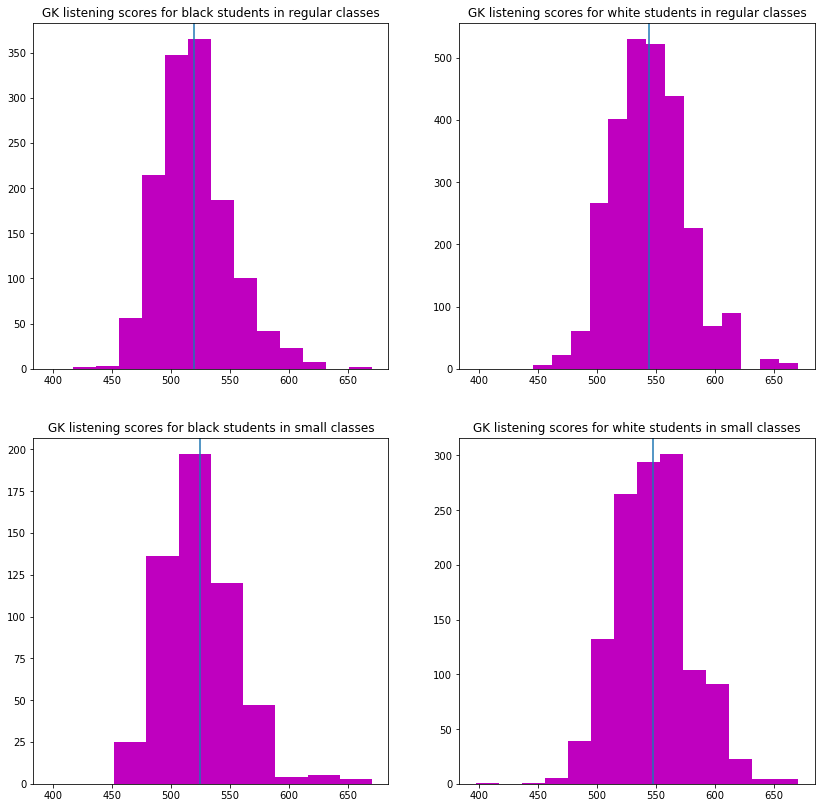

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_reg_kl.gktlstnss, bins=bin_counts(data_b_reg_kl.gktlstnss), color='m', range=(l_lb1, l_ub1))
axes[0, 0].axvline(x = data_b_reg_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK listening scores for black students in regular classes')

axes[0, 1].hist(data_w_reg_kl.gktlstnss, bins=bin_counts(data_w_reg_kl.gktlstnss), color='m', range=(l_lb1, l_ub1))
axes[0, 1].axvline(x = data_w_reg_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK listening scores for white students in regular classes')

axes[1, 0].hist(data_b_small_kl.gktlstnss, bins=bin_counts(data_b_small_kl.gktlstnss), color='m', range=(l_lb1, l_ub1))
axes[1, 0].axvline(x = data_b_small_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK listening scores for black students in small classes')

axes[1, 1].hist(data_w_small_kl.gktlstnss, bins=bin_counts(data_w_small_kl.gktlstnss), color='m', range=(l_lb1, l_ub1))
axes[1, 1].axvline(x = data_w_small_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK listening scores for white students in small classes')

plt.show()

In [41]:
print('Summary statistics for GK listening, black students in regular classes:\n{}'.format(data_b_reg_kl.gktlstnss.describe()))
print('Summary statistics for GK listening, black students in small classes:\n{}'.format(data_b_small_kl.gktlstnss.describe()))
print('Summary statistics for GK listening, white students in regular classes:\n{}'.format(data_w_reg_kl.gktlstnss.describe()))
print('Summary statistics for GK listening, white students in small classes:\n{}'.format(data_w_small_kl.gktlstnss.describe()))

Summary statistics for GK listening, black students in regular classes:
count    1350.000000
mean      519.742963
std        29.713355
min       427.000000
25%       498.000000
50%       516.000000
75%       536.000000
max       671.000000
Name: gktlstnss, dtype: float64
Summary statistics for GK listening, black students in small classes:
count    537.000000
mean     524.774674
std       31.270418
min      452.000000
25%      501.000000
50%      524.000000
75%      540.000000
max      671.000000
Name: gktlstnss, dtype: float64
Summary statistics for GK listening, white students in regular classes:
count    2657.000000
mean      544.517501
std        31.485937
min       457.000000
25%       524.000000
50%       545.000000
75%       565.000000
max       671.000000
Name: gktlstnss, dtype: float64
Summary statistics for GK listening, white students in small classes:
count    1264.000000
mean      547.253165
std        31.679574
min       397.000000
25%       528.000000
50%       545.00000

For white students in small classes, the listening test shows the lowest effect size yet. The p-value is still below the generally used threshold of 0.05.

In [42]:
stats.ttest_ind(data_b_reg_kl.gktlstnss, data_b_small_kl.gktlstnss, equal_var=False)

# for black students

Ttest_indResult(statistic=-3.1984191247770712, pvalue=0.001427958069869377)

In [43]:
stats.ttest_ind(data_w_reg_kl.gktlstnss, data_w_small_kl.gktlstnss, equal_var=False)

# for white students

Ttest_indResult(statistic=-2.532264480815551, pvalue=0.011394330115464984)

In [44]:
print("Cohen's d for black kindergarten students, listening:", cohend(data_b_small_kl.gktlstnss, data_b_reg_kl.gktlstnss))
print("Cohen's d for white kindergarten students, listening:", cohend(data_w_small_kl.gktlstnss, data_w_reg_kl.gktlstnss))

Cohen's d for black kindergarten students, listening: 0.166808233375
Cohen's d for white kindergarten students, listening: 0.0867129836379


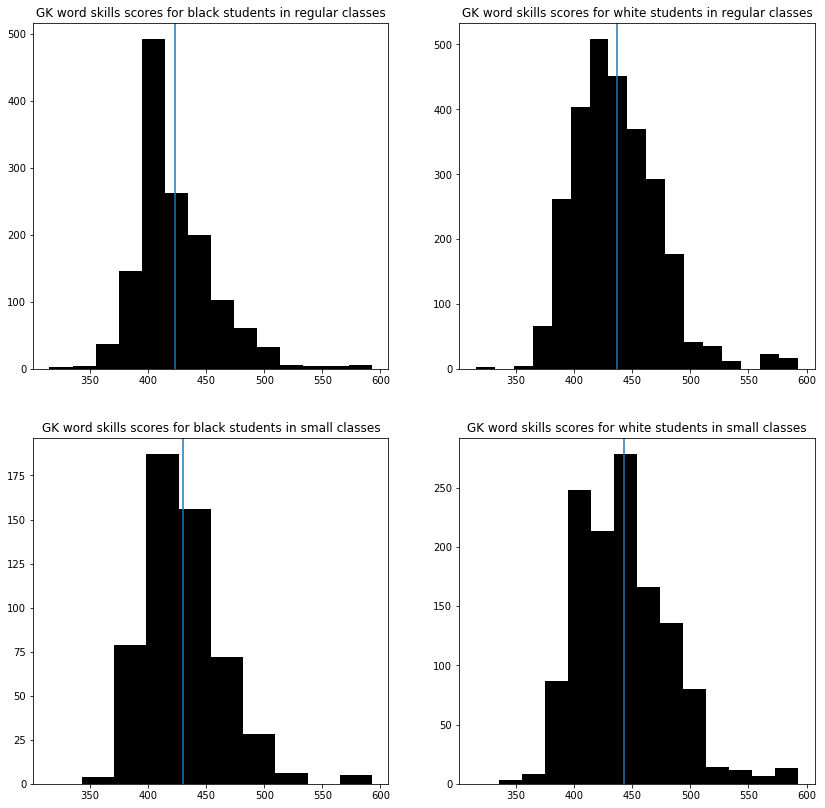

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_reg_kw.gktwordss, bins=bin_counts(data_b_reg_kw.gktwordss), color='black', range=(w_lb1, w_ub1))
axes[0, 0].axvline(x = data_b_reg_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK word skills scores for black students in regular classes')

axes[0, 1].hist(data_w_reg_kw.gktwordss, bins=bin_counts(data_w_reg_kw.gktwordss), color='black', range=(w_lb1, w_ub1))
axes[0, 1].axvline(x = data_w_reg_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK word skills scores for white students in regular classes')

axes[1, 0].hist(data_b_small_kw.gktwordss, bins=bin_counts(data_b_small_kw.gktwordss), color='black', range=(w_lb1, w_ub1))
axes[1, 0].axvline(x = data_b_small_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK word skills scores for black students in small classes')

axes[1, 1].hist(data_w_small_kw.gktwordss, bins=bin_counts(data_w_small_kw.gktwordss), color='black', range=(w_lb1, w_ub1))
axes[1, 1].axvline(x = data_w_small_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK word skills scores for white students in small classes')

plt.show()

In [46]:
print('Summary statistics for GK word skills, black students in regular classes:\n{}'.format(data_b_reg_kw.gktwordss.describe()))
print('Summary statistics for GK word skills, black students in small classes:\n{}'.format(data_b_small_kw.gktwordss.describe()))
print('Summary statistics for GK word skills, white students in regular classes:\n{}'.format(data_w_reg_kw.gktwordss.describe()))
print('Summary statistics for GK word skills, white students in small classes:\n{}'.format(data_w_small_kw.gktwordss.describe()))

Summary statistics for GK word skills, black students in regular classes:
count    1358.000000
mean      423.257732
std        33.145042
min       331.000000
25%       401.000000
50%       414.000000
75%       440.000000
max       593.000000
Name: gktwordss, dtype: float64
Summary statistics for GK word skills, black students in small classes:
count    537.000000
mean     430.288641
std       34.154507
min      361.000000
25%      405.000000
50%      423.000000
75%      453.000000
max      593.000000
Name: gktwordss, dtype: float64
Summary statistics for GK word skills, white students in regular classes:
count    2662.000000
mean      436.456048
std        36.376184
min       315.000000
25%       410.000000
50%       431.000000
75%       458.000000
max       593.000000
Name: gktwordss, dtype: float64
Summary statistics for GK word skills, white students in small classes:
count    1265.000000
mean      442.588142
std        38.951674
min       343.000000
25%       414.000000
50%       4

The word skills test shows results similar to those of the reading test.

In [47]:
stats.ttest_ind(data_b_reg_kw.gktwordss, data_b_small_kw.gktwordss, equal_var=False)

# for black students

Ttest_indResult(statistic=-4.0720154430593496, pvalue=5.0460100804223023e-05)

In [48]:
stats.ttest_ind(data_w_reg_kw.gktwordss, data_w_small_kw.gktwordss, equal_var=False)

# for white students

Ttest_indResult(statistic=-4.7079872013469339, pvalue=2.6480719973843307e-06)

In [49]:
print("Cohen's d for black kindergarten students, word skills:", cohend(data_b_small_kw.gktwordss, data_b_reg_kw.gktwordss))
print("Cohen's d for white kindergarten students, word skills:", cohend(data_w_small_kw.gktwordss, data_w_reg_kw.gktwordss))

Cohen's d for black kindergarten students, word skills: 0.21029094257
Cohen's d for white kindergarten students, word skills: 0.164729281613


There is strong evidence that both black and white students perform better in small classes. This pattern is apparent in all four tests.

# The impact of class size on college aspirations

In [50]:
data_b_reg_test = data_b_reg[['hstest']].dropna()
data_b_small_test = data_b_small[['hstest']].dropna()
data_w_reg_test = data_w_reg[['hstest']].dropna()
data_w_small_test = data_w_small[['hstest']].dropna()

The grouped bar graph below shows the proportion of students who went on to take a college entrance examination (SAT or ACT). Taking such a test is a sign that the student is interested in pursuing higher education. The graph indicates that the students assigned to small classes in grades K–3 register for these examinations at a notably higher rate. The difference is especially significant for black students.

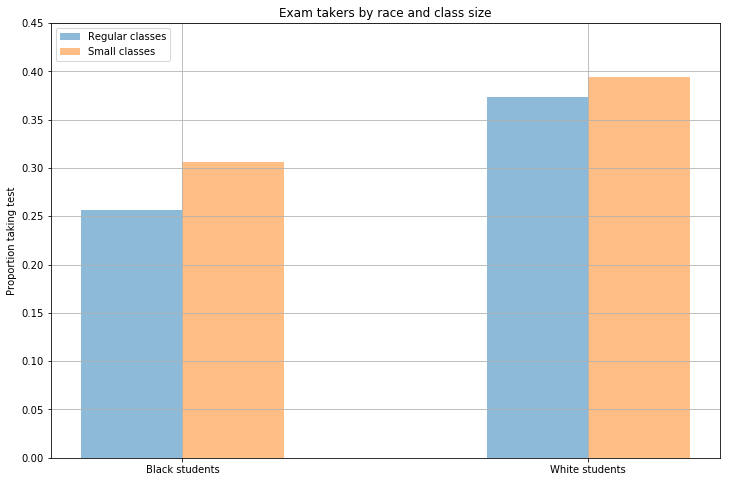

In [51]:
pos = [0, 1]
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))

plt.bar(pos, (data_b_reg_test['hstest'].mean(), data_w_reg_test['hstest'].mean()),
        width, alpha=0.5, label='Regular')

plt.bar([p + width for p in pos], (data_b_small_test['hstest'].mean(), data_w_small_test['hstest'].mean()),
        width, alpha=0.5, label='Small')

ax.set_ylabel('Proportion taking test')
ax.set_title('Exam takers by race and class size')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(['Black students', 'White students'])
ax.set_ylim([0, 0.45])
ax.set_yticks(np.linspace(0, 0.45, 10))

plt.legend(['Regular classes', 'Small classes'], loc='upper left')
plt.grid()
plt.show()

In [52]:
print('Summary statistics for test registration, black students in regular classes:\n{}'.format(data_b_reg_test.hstest.describe()))
print('Summary statistics for test registration, black students in small classes:\n{}'.format(data_b_small_test.hstest.describe()))
print('Summary statistics for test registration, white students in regular classes:\n{}'.format(data_w_reg_test.hstest.describe()))
print('Summary statistics for test registration, white students in small classes:\n{}'.format(data_w_small_test.hstest.describe()))

Summary statistics for test registration, black students in regular classes:
count    3144.000000
mean        0.256679
std         0.436870
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: hstest, dtype: float64
Summary statistics for test registration, black students in small classes:
count    1036.000000
mean        0.305985
std         0.461046
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: hstest, dtype: float64
Summary statistics for test registration, white students in regular classes:
count    5097.000000
mean        0.373161
std         0.483692
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: hstest, dtype: float64
Summary statistics for test registration, white students in small classes:
count    2101.000000
mean        0.393622
std         0.488669
min         0.000000
25%         0.000000


We conduct Fisher's exact test on the 2-by-2 contingency table for each race. In each table, the variables are test status (took or did not take) and K–3 class size (small or regular). The null hypothesis is that test status and class size are independent. The p-value represents the probability that we would see a deviation at least as large as the one we observed if the null hypothesis were true. A lower p-value is stronger evidence against the null hypothesis.

In [53]:
oddsratio_b, p_b = stats.fisher_exact([[data_b_reg_test.hstest.sum(), len(data_b_reg_test.hstest) - data_b_reg_test.hstest.sum()],
                                        [data_b_small_test.hstest.sum(), len(data_b_small_test.hstest) - data_b_small_test.hstest.sum()]])

p_b

# for black students

0.0021325225531637652

In [54]:
oddsratio_w, p_w = stats.fisher_exact([[data_w_reg_test.hstest.sum(), len(data_w_reg_test.hstest) - data_w_reg_test.hstest.sum()],
                                        [data_w_small_test.hstest.sum(), len(data_w_small_test.hstest) - data_w_small_test.hstest.sum()]])

p_w

# for white students

0.10889837078613851

The hypothesis test shows that small classes almost certainly have a positive effect on college aspirations for black students. For white students, we are not able to reject the null hypothesis; further research will be needed.

# Does teacher race have an effect?

We conduct hypothesis testing to see whether the race of a teacher has an impact on students' mean test scores. We split our data into four groups based on race of the student and race of the teacher. Again, only black and white students and teachers were considered because there were too few observations for the other races.

In [55]:
data_b_tb = dataB[dataB['ktwhite'] == 0]
data_b_tw = dataB[dataB['ktwhite'] == 1]
data_w_tb = dataW[dataW['ktwhite'] == 0]
data_w_tw = dataW[dataW['ktwhite'] == 1]

In [56]:
data_b_tb_kr = data_b_tb[['gktreadss']].dropna()
data_b_tw_kr = data_b_tw[['gktreadss']].dropna()
data_w_tb_kr = data_w_tb[['gktreadss']].dropna()
data_w_tw_kr = data_w_tw[['gktreadss']].dropna()

data_b_tb_km = data_b_tb[['gktmathss']].dropna()
data_b_tw_km = data_b_tw[['gktmathss']].dropna()
data_w_tb_km = data_w_tb[['gktmathss']].dropna()
data_w_tw_km = data_w_tw[['gktmathss']].dropna()

data_b_tb_kl = data_b_tb[['gktlstnss']].dropna()
data_b_tw_kl = data_b_tw[['gktlstnss']].dropna()
data_w_tb_kl = data_w_tb[['gktlstnss']].dropna()
data_w_tw_kl = data_w_tw[['gktlstnss']].dropna()

data_b_tb_kw = data_b_tb[['gktwordss']].dropna()
data_b_tw_kw = data_b_tw[['gktwordss']].dropna()
data_w_tb_kw = data_w_tb[['gktwordss']].dropna()
data_w_tw_kw = data_w_tw[['gktwordss']].dropna()

In [57]:
r_lb2 = min(min(data_b_tb_kr.values)[0], min(data_b_tw_kr.values)[0], min(data_w_tb_kr.values)[0], min(data_w_tw_kr.values)[0])
r_ub2 = max(max(data_b_tb_kr.values)[0], max(data_b_tw_kr.values)[0], max(data_w_tb_kr.values)[0], max(data_w_tw_kr.values)[0])
m_lb2 = min(min(data_b_tb_km.values)[0], min(data_b_tw_km.values)[0], min(data_w_tb_km.values)[0], min(data_w_tw_km.values)[0])
m_ub2 = max(max(data_b_tb_km.values)[0], max(data_b_tw_km.values)[0], max(data_w_tb_km.values)[0], max(data_w_tw_km.values)[0])
l_lb2 = min(min(data_b_tb_kl.values)[0], min(data_b_tw_kl.values)[0], min(data_w_tb_kl.values)[0], min(data_w_tw_kl.values)[0])
l_ub2 = max(max(data_b_tb_kl.values)[0], max(data_b_tw_kl.values)[0], max(data_w_tb_kl.values)[0], max(data_w_tw_kl.values)[0])
w_lb2 = min(min(data_b_tb_kw.values)[0], min(data_b_tw_kw.values)[0], min(data_w_tb_kw.values)[0], min(data_w_tw_kw.values)[0])
w_ub2 = max(max(data_b_tb_kw.values)[0], max(data_b_tw_kw.values)[0], max(data_w_tb_kw.values)[0], max(data_w_tw_kw.values)[0])

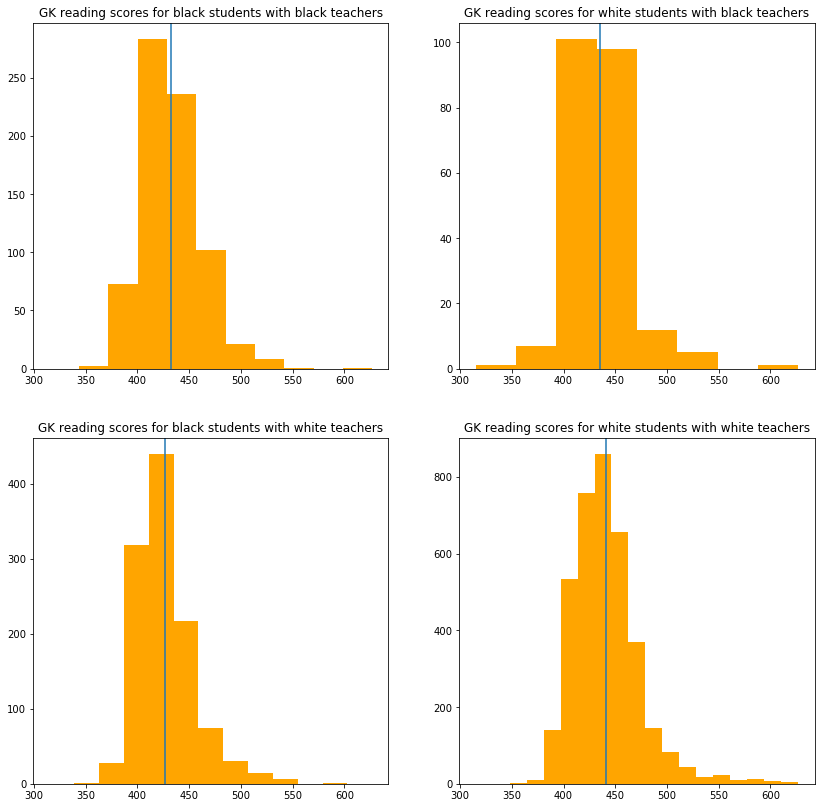

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_tb_kr.gktreadss, bins=bin_counts(data_b_tb_kr.gktreadss), color='orange', range=(r_lb2, r_ub2))
axes[0, 0].axvline(x = data_b_tb_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK reading scores for black students with black teachers')

axes[0, 1].hist(data_w_tb_kr.gktreadss, bins=bin_counts(data_w_tb_kr.gktreadss), color='orange', range=(r_lb2, r_ub2))
axes[0, 1].axvline(x = data_w_tb_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK reading scores for white students with black teachers')

axes[1, 0].hist(data_b_tw_kr.gktreadss, bins=bin_counts(data_b_tw_kr.gktreadss), color='orange', range=(r_lb2, r_ub2))
axes[1, 0].axvline(x = data_b_tw_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK reading scores for black students with white teachers')

axes[1, 1].hist(data_w_tw_kr.gktreadss, bins=bin_counts(data_w_tw_kr.gktreadss), color='orange', range=(r_lb2, r_ub2))
axes[1, 1].axvline(x = data_w_tw_kr.gktreadss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK reading scores for white students with white teachers')

plt.show()

In [59]:
print('Summary statistics for GK reading, black students with black teachers:\n{}'.format(data_b_tb_kr.gktreadss.describe()))
print('Summary statistics for GK reading, black students with white teachers:\n{}'.format(data_b_tw_kr.gktreadss.describe()))
print('Summary statistics for GK reading, white students with black teachers:\n{}'.format(data_w_tb_kr.gktreadss.describe()))
print('Summary statistics for GK reading, white students with white teachers:\n{}'.format(data_w_tw_kr.gktreadss.describe()))

Summary statistics for GK reading, black students with black teachers:
count    727.000000
mean     432.711142
std       28.668365
min      346.000000
25%      413.000000
50%      430.000000
75%      448.000000
max      627.000000
Name: gktreadss, dtype: float64
Summary statistics for GK reading, black students with white teachers:
count    1131.000000
mean      426.486295
std        28.579381
min       360.000000
25%       407.000000
50%       421.000000
75%       439.000000
max       580.000000
Name: gktreadss, dtype: float64
Summary statistics for GK reading, white students with black teachers:
count    225.000000
mean     435.168889
std       31.338559
min      315.000000
25%      414.000000
50%      434.000000
75%      450.000000
max      605.000000
Name: gktreadss, dtype: float64
Summary statistics for GK reading, white students with white teachers:
count    3678.000000
mean      440.730016
std        32.356286
min       358.000000
25%       419.000000
50%       436.000000
75%   

There is extremely strong evidence that there is a true difference for black students and strong evidence that there is a true difference for white students. Black kindergarten students appear to perform slightly better with black teachers, while white kindergarten students appear to perform slightly better with white teachers. However, it should be noted that the effect size is relatively small: approximately 6 points.

In [60]:
stats.ttest_ind(data_b_tb_kr.gktreadss, data_b_tw_kr.gktreadss, equal_var=False)

# for black students

Ttest_indResult(statistic=4.5732889575669509, pvalue=5.184367762418898e-06)

In [61]:
stats.ttest_ind(data_w_tb_kr.gktreadss, data_w_tw_kr.gktreadss, equal_var=False)

# for white students

Ttest_indResult(statistic=-2.5790334751394921, pvalue=0.010470921873543466)

In [62]:
print("Cohen's d for black kindergarten students, reading:", cohend(data_b_tb_kr.gktreadss, data_b_tw_kr.gktreadss))
print("Cohen's d for white kindergarten students, reading:", cohend(data_w_tw_kr.gktreadss, data_w_tb_kr.gktreadss))

Cohen's d for black kindergarten students, reading: 0.217543720853
Cohen's d for white kindergarten students, reading: 0.172179190334


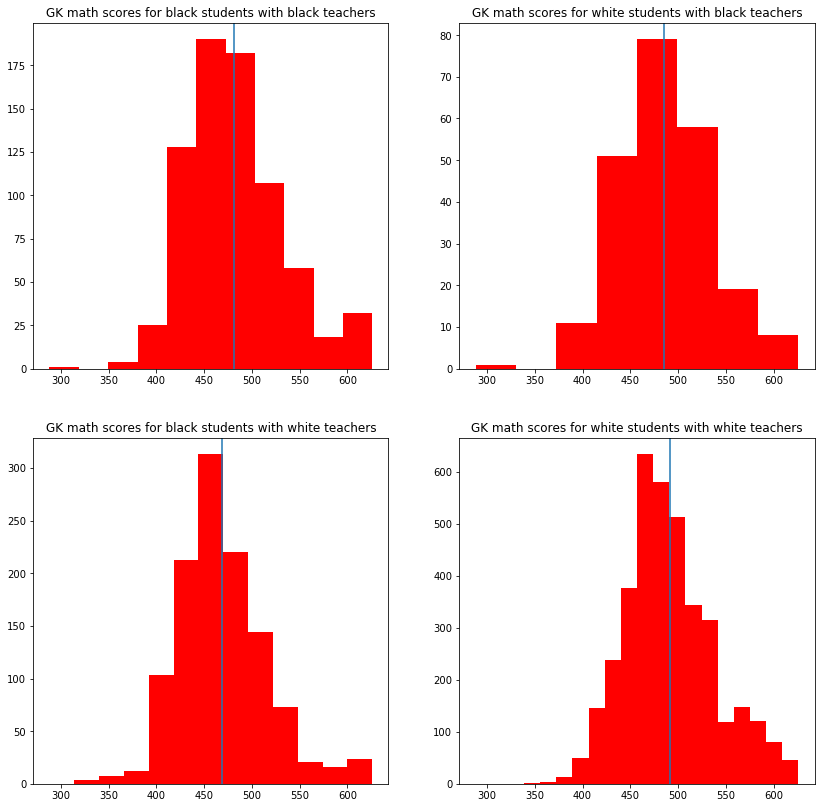

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_tb_km.gktmathss, bins=bin_counts(data_b_tb_km.gktmathss), color='r', range=(m_lb2, m_ub2))
axes[0, 0].axvline(x = data_b_tb_km.gktmathss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK math scores for black students with black teachers')

axes[0, 1].hist(data_w_tb_km.gktmathss, bins=bin_counts(data_w_tb_km.gktmathss), color='r', range=(m_lb2, m_ub2))
axes[0, 1].axvline(x = data_w_tb_km.gktmathss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK math scores for white students with black teachers')

axes[1, 0].hist(data_b_tw_km.gktmathss, bins=bin_counts(data_b_tw_km.gktmathss), color='r', range=(m_lb2, m_ub2))
axes[1, 0].axvline(x = data_b_tw_km.gktmathss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK math scores for black students with white teachers')

axes[1, 1].hist(data_w_tw_km.gktmathss, bins=bin_counts(data_w_tw_km.gktmathss), color='r', range=(m_lb2, m_ub2))
axes[1, 1].axvline(x = data_w_tw_km.gktmathss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK math scores for white students with white teachers')

plt.show()

In [64]:
print('Summary statistics for GK math, black students with black teachers:\n{}'.format(data_b_tb_km.gktmathss.describe()))
print('Summary statistics for GK math, black students with white teachers:\n{}'.format(data_b_tw_km.gktmathss.describe()))
print('Summary statistics for GK math, white students with black teachers:\n{}'.format(data_w_tb_km.gktmathss.describe()))
print('Summary statistics for GK math, white students with white teachers:\n{}'.format(data_w_tw_km.gktmathss.describe()))

Summary statistics for GK math, black students with black teachers:
count    745.000000
mean     481.212081
std       49.725841
min      288.000000
25%      444.000000
50%      473.000000
75%      506.000000
max      626.000000
Name: gktmathss, dtype: float64
Summary statistics for GK math, black students with white teachers:
count    1150.000000
mean      468.370435
std        47.436570
min       320.000000
25%       434.000000
50%       463.000000
75%       494.000000
max       626.000000
Name: gktmathss, dtype: float64
Summary statistics for GK math, white students with black teachers:
count    227.000000
mean     484.797357
std       47.670452
min      320.000000
25%      454.000000
50%      478.000000
75%      513.000000
max      626.000000
Name: gktmathss, dtype: float64
Summary statistics for GK math, white students with white teachers:
count    3721.000000
mean      491.537221
std        45.962400
min       339.000000
25%       459.000000
50%       489.000000
75%       520.0000

For math, the evidence is again overwhelming for the black students but weaker (just under the widely used threshold of 0.05) for the white students. The difference for black students is about 13 points and for white students about 7 points.

In [65]:
stats.ttest_ind(data_b_tb_km.gktmathss, data_b_tw_km.gktmathss, equal_var=False)

# for black students

Ttest_indResult(statistic=5.5908723160169504, pvalue=2.669973069960416e-08)

In [66]:
stats.ttest_ind(data_w_tb_km.gktmathss, data_w_tw_km.gktmathss, equal_var=False)

# for white students

Ttest_indResult(statistic=-2.0722232549976236, pvalue=0.039260501927899094)

In [67]:
print("Cohen's d for black kindergarten students, math:", cohend(data_b_tb_km.gktmathss, data_b_tw_km.gktmathss))
print("Cohen's d for white kindergarten students, math:", cohend(data_w_tw_km.gktmathss, data_w_tb_km.gktmathss))

Cohen's d for black kindergarten students, math: 0.265600352013
Cohen's d for white kindergarten students, math: 0.146320541636


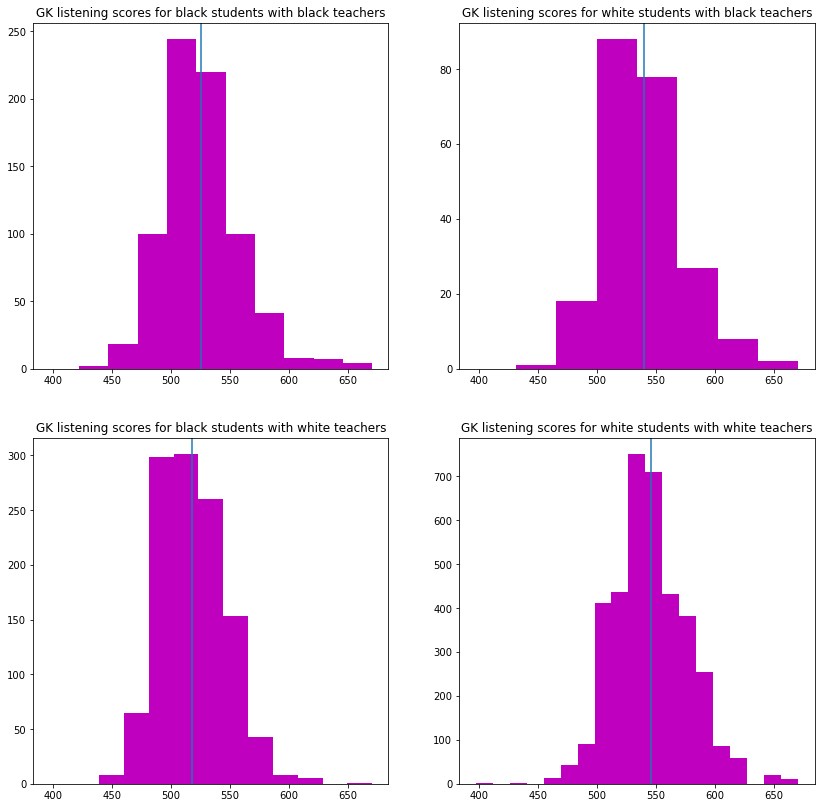

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_tb_kl.gktlstnss, bins=bin_counts(data_b_tb_kl.gktlstnss), color='m', range=(l_lb2, l_ub2))
axes[0, 0].axvline(x = data_b_tb_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK listening scores for black students with black teachers')

axes[0, 1].hist(data_w_tb_kl.gktlstnss, bins=bin_counts(data_w_tb_kl.gktlstnss), color='m', range=(l_lb2, l_ub2))
axes[0, 1].axvline(x = data_w_tb_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK listening scores for white students with black teachers')

axes[1, 0].hist(data_b_tw_kl.gktlstnss, bins=bin_counts(data_b_tw_kl.gktlstnss), color='m', range=(l_lb2, l_ub2))
axes[1, 0].axvline(x = data_b_tw_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK listening scores for black students with white teachers')

axes[1, 1].hist(data_w_tw_kl.gktlstnss, bins=bin_counts(data_w_tw_kl.gktlstnss), color='m', range=(l_lb2, l_ub2))
axes[1, 1].axvline(x = data_w_tw_kl.gktlstnss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK listening scores for white students with white teachers')

plt.show()

In [69]:
print('Summary statistics for GK listening, black students with black teachers:\n{}'.format(data_b_tb_kl.gktlstnss.describe()))
print('Summary statistics for GK listening, black students with white teachers:\n{}'.format(data_b_tw_kl.gktlstnss.describe()))
print('Summary statistics for GK listening, white students with black teachers:\n{}'.format(data_w_tb_kl.gktlstnss.describe()))
print('Summary statistics for GK listening, white students with white teachers:\n{}'.format(data_w_tw_kl.gktlstnss.describe()))

Summary statistics for GK listening, black students with black teachers:
count    744.000000
mean     525.888441
std       32.747571
min      427.000000
25%      505.000000
50%      524.000000
75%      541.250000
max      671.000000
Name: gktlstnss, dtype: float64
Summary statistics for GK listening, black students with white teachers:
count    1143.000000
mean      518.106737
std        28.085013
min       452.000000
25%       498.000000
50%       516.000000
75%       532.000000
max       671.000000
Name: gktlstnss, dtype: float64
Summary statistics for GK listening, white students with black teachers:
count    222.00000
mean     539.77027
std       31.82242
min      461.00000
25%      520.00000
50%      536.00000
75%      560.00000
max      671.00000
Name: gktlstnss, dtype: float64
Summary statistics for GK listening, white students with white teachers:
count    3699.000000
mean      545.737226
std        31.527536
min       397.000000
25%       524.000000
50%       545.000000
75%   

Black kindergarten students perform approximately 8 points better when they have black teachers, while white kindergarten students perform approximately 6 points better with white teachers.

In [70]:
stats.ttest_ind(data_b_tb_kl.gktlstnss, data_b_tw_kl.gktlstnss, equal_var=False)

# for black students

Ttest_indResult(statistic=5.3300742588946717, pvalue=1.1413298892446658e-07)

In [71]:
stats.ttest_ind(data_w_tb_kl.gktlstnss, data_w_tw_kl.gktlstnss, equal_var=False)

# for white students

Ttest_indResult(statistic=-2.7149808836499427, pvalue=0.00709409754439094)

In [72]:
print("Cohen's d for black kindergarten students, listening:", cohend(data_b_tb_kl.gktlstnss, data_b_tw_kl.gktlstnss))
print("Cohen's d for white kindergarten students, listening:", cohend(data_w_tw_kl.gktlstnss, data_w_tb_kl.gktlstnss))

Cohen's d for black kindergarten students, listening: 0.259303896132
Cohen's d for white kindergarten students, listening: 0.189161112904


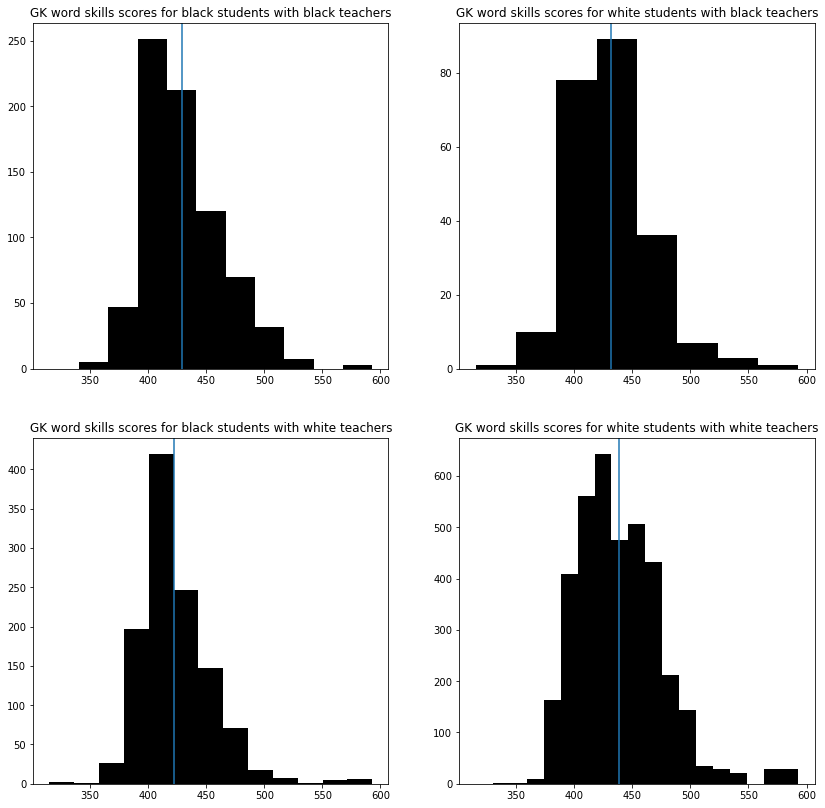

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].hist(data_b_tb_kw.gktwordss, bins=bin_counts(data_b_tb_kw.gktwordss), color='black', range=(w_lb2, w_ub2))
axes[0, 0].axvline(x = data_b_tb_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[0, 0].set_title('GK word skills scores for black students with black teachers')

axes[0, 1].hist(data_w_tb_kw.gktwordss, bins=bin_counts(data_w_tb_kw.gktwordss), color='black', range=(w_lb2, w_ub2))
axes[0, 1].axvline(x = data_w_tb_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[0, 1].set_title('GK word skills scores for white students with black teachers')

axes[1, 0].hist(data_b_tw_kw.gktwordss, bins=bin_counts(data_b_tw_kw.gktwordss), color='black', range=(w_lb2, w_ub2))
axes[1, 0].axvline(x = data_b_tw_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[1, 0].set_title('GK word skills scores for black students with white teachers')

axes[1, 1].hist(data_w_tw_kw.gktwordss, bins=bin_counts(data_w_tw_kw.gktwordss), color='black', range=(w_lb2, w_ub2))
axes[1, 1].axvline(x = data_w_tw_kw.gktwordss.mean(), ymin=0, ymax=1)
axes[1, 1].set_title('GK word skills scores for white students with white teachers')

plt.show()

In [74]:
print('Summary statistics for GK word skills, black students with black teachers:\n{}'.format(data_b_tb_kw.gktwordss.describe()))
print('Summary statistics for GK word skills, black students with white teachers:\n{}'.format(data_b_tw_kw.gktwordss.describe()))
print('Summary statistics for GK word skills, white students with black teachers:\n{}'.format(data_w_tb_kw.gktwordss.describe()))
print('Summary statistics for GK word skills, white students with white teachers:\n{}'.format(data_w_tw_kw.gktwordss.describe()))

Summary statistics for GK word skills, black students with black teachers:
count    747.000000
mean     429.246319
std       34.234499
min      353.000000
25%      405.000000
50%      423.000000
75%      449.000000
max      593.000000
Name: gktwordss, dtype: float64
Summary statistics for GK word skills, black students with white teachers:
count    1148.000000
mean      422.649826
std        32.893997
min       331.000000
25%       401.000000
50%       414.000000
75%       435.000000
max       593.000000
Name: gktwordss, dtype: float64
Summary statistics for GK word skills, white students with black teachers:
count    225.000000
mean     431.542222
std       33.780928
min      315.000000
25%      410.000000
50%      431.000000
75%      453.000000
max      593.000000
Name: gktwordss, dtype: float64
Summary statistics for GK word skills, white students with white teachers:
count    3702.000000
mean      438.850081
std        37.498763
min       331.000000
25%       410.000000
50%       4

Here black kindergarten students perform about 7 points better with black teachers, while white kindergarten students perform about 7 points better with white teachers. 

In [75]:
stats.ttest_ind(data_b_tb_kw.gktwordss, data_b_tw_kw.gktwordss, equal_var=False)

# for black students

Ttest_indResult(statistic=4.162454416173655, pvalue=3.321720415441053e-05)

In [76]:
stats.ttest_ind(data_w_tb_kw.gktwordss, data_w_tw_kw.gktwordss, equal_var=False)

# for white students

Ttest_indResult(statistic=-3.1298776788227034, pvalue=0.0019492519459142572)

In [77]:
print("Cohen's d for black kindergarten students, word skills:", cohend(data_b_tb_kw.gktwordss, data_b_tw_kw.gktwordss))
print("Cohen's d for white kindergarten students, word skills:", cohend(data_w_tw_kw.gktwordss, data_w_tb_kw.gktwordss))

Cohen's d for black kindergarten students, word skills: 0.197329424162
Cohen's d for white kindergarten students, word skills: 0.195943436072


Black kindergarten students appear to perform better with black teachers, even though the effect size is small (ranging from about 6 to 13 points). Similarly, white kindergarten students perform better with white teachers, although the p-values are higher.

This pattern is apparent in all four tests.